# Comparativo metodologias: RQA+FS vs. RP+CNN
---



# Ambiente

In [1]:
import os, sys, pickle
import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 10)
%matplotlib inline
from matplotlib.image import imsave
from PIL import Image

from nilmtk.dataset_converters import convert_redd

from nilmtk import DataSet
from nilmtk.utils import print_dict

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings(action="ignore")

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pyts.image import RecurrencePlot

from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computing_type import ComputingType
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

import seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

In [2]:
dataset_path = "datasets/REDD/low_freq"

windows_data_path = os.path.join(dataset_path, "../../phd")

# Coleta e limpeza dos dados (OPCIONAL)

In [3]:
dataset_path = "datasets/REDD/low_freq"

windows_data_path = os.path.join(dataset_path, "../../phd")
if not os.path.isdir(windows_data_path):
    os.makedirs(windows_data_path)

dataset_file = "datasets/REDD/redd.h5"
if not os.path.isfile(dataset_file):
    convert_redd(dataset_path, dataset_file)
    
sample_rate = 3

In [4]:
redd = DataSet(dataset_file)
print_dict(redd.metadata)

In [5]:
house_3 = redd.buildings[3]
print(house_3.elec)

MeterGroup(meters=
  ElecMeter(instance=1, building=3, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=3, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=3, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=4, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=5, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=3, dataset='REDD', appliances=[Appliance(type='CE appliance', instance=1)])
  ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=3, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])
  ElecMeter(instance=9, building=3, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=10, building=3, dataset='REDD', appliances=[Appliance(ty

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


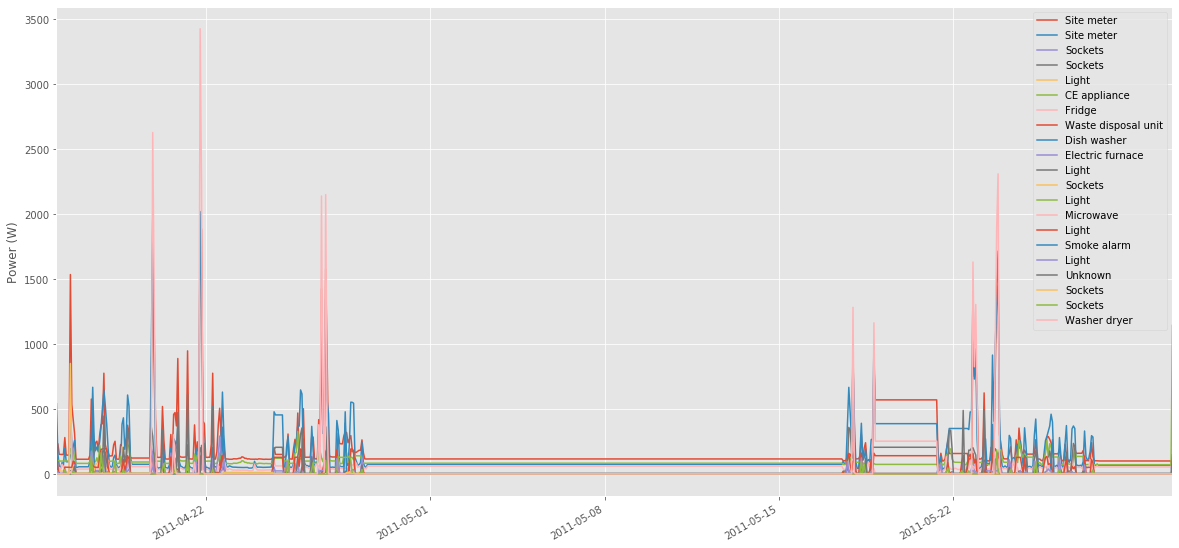

In [6]:
fig = plt.figure(figsize=(20, 10))
house_3.elec.plot();

In [7]:
# Amostras de Originais de Mains
house_3.elec.mains().power_series_all_data().head()

Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')      ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


2011-04-16 01:11:27-04:00    757.089966
2011-04-16 01:11:28-04:00    758.890015
2011-04-16 01:11:29-04:00    758.889954
2011-04-16 01:11:30-04:00    758.640015
2011-04-16 01:11:31-04:00    756.640015
Name: (power, apparent), dtype: float32

In [8]:
house_3.elec[1].power_series_all_data(sample_period=3).shape

(1290170,)

In [9]:
# Amostras de Originais de Aplpiance 3
house_3.elec[3].power_series_all_data().head()

2011-04-16 01:11:30-04:00    2.0
2011-04-16 01:11:33-04:00    1.0
2011-04-16 01:11:36-04:00    1.0
2011-04-16 01:11:40-04:00    2.0
2011-04-16 01:11:43-04:00    1.0
Name: (power, active), dtype: float32

In [10]:
house_3.elec[3].power_series_all_data(sample_period=3).shape

(1290163,)

**CONCLUSÃO PARCIAL:** É possível observar a diferenca de frequencias (mains e appliances, 1 e 3 segundos, respectivamente)

In [11]:
# Forçando taxa de 3 segundos para Mains
house_3.elec[1].power_series_all_data(sample_period=3).head()

2011-04-16 01:11:27-04:00    180.850006
2011-04-16 01:11:30-04:00    180.823334
2011-04-16 01:11:33-04:00    181.839996
2011-04-16 01:11:36-04:00    180.976669
2011-04-16 01:11:39-04:00    180.643341
Name: (power, apparent), dtype: float32

In [12]:
house_3.elec[1].power_series_all_data(sample_period=3).shape

(1290170,)

**CONCLUSÃO PARCIAL**: é possível normalizar as frequências, através do parâmetro `sample_period=SECOND_RATE`. Neste estudo, iremos `fixar esta taxa em 3 segundos`, tanto para as correntes princiais (medição geral - mains 1 e 2) quanto para os aparelhos.

Agora iremos verificar o intervalo de dados medidos, a fim de saber em quais momentos se iniciam e terminam os registros, tanto para `mains` quanto para os `appliances`.

In [13]:
# Mains
print("Mains head: ")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).head())
# Appliance 4
print("Appliance head: ")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).head())

print("- "*33, "\n")
print("Mains tail:")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).tail())

print("Appliance tail:")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).tail())

Mains head: 


2011-04-16 01:11:27-04:00    180.850006
2011-04-16 01:11:30-04:00    180.823334
2011-04-16 01:11:33-04:00    181.839996
2011-04-16 01:11:36-04:00    180.976669
2011-04-16 01:11:39-04:00    180.643341
Name: (power, apparent), dtype: float32

Appliance head: 


2011-04-16 01:11:30-04:00    0.0
2011-04-16 01:11:33-04:00    0.0
2011-04-16 01:11:36-04:00    0.0
2011-04-16 01:11:39-04:00    0.0
2011-04-16 01:11:42-04:00    0.0
Name: (power, active), dtype: float32

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Mains tail:


2011-05-30 20:19:42-04:00    15.46
2011-05-30 20:19:45-04:00    15.43
2011-05-30 20:19:48-04:00    15.44
2011-05-30 20:19:51-04:00    15.47
2011-05-30 20:19:54-04:00    15.46
Name: (power, apparent), dtype: float32

Appliance tail:


2011-05-30 20:19:24-04:00    1.0
2011-05-30 20:19:27-04:00    1.0
2011-05-30 20:19:30-04:00    1.0
2011-05-30 20:19:33-04:00    1.0
2011-05-30 20:19:36-04:00    1.0
Name: (power, active), dtype: float32

**IMPORTANTE:** É possível observar algumas inconsitências quanto ao intervalo:

    1. O primeiro registro de  `mains` é anterior ao primeiro registro do `appliance;
    2. O último registro de `appliance` é anterior ao último de `mains`.
    
Neste caso, iremos deimiltar o início e o fim das medições com base no primeiro e último *timestamp* de `appliances`, sendo estes `2011-04-16 01:11:30` e `2011-05-30 20:19:36`, respectivamente.

In [14]:
redd.set_window(
    #start='2011-04-16 01:11:30', 
    #end='2011-05-30 20:19:36'
    start='2011-04-16 05:11:30',
    end='2011-04-23 08:43:26'
)
house_3 = redd.buildings[3]

In [15]:
# Mains
print("Mains head: ")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).head())
# Appliance 4
print("Appliance head: ")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).head())

print("- "*33, "\n")
print("Mains tail:")
display(house_3.elec[1].power_series_all_data(sample_period=sample_rate).tail())

print("Appliance tail:")
display(house_3.elec[4].power_series_all_data(sample_period=sample_rate).tail())

Mains head: 


2011-04-16 05:11:30-04:00    144.820007
2011-04-16 05:11:33-04:00    146.666672
2011-04-16 05:11:36-04:00    146.009995
2011-04-16 05:11:39-04:00    144.856674
2011-04-16 05:11:42-04:00    144.550003
Name: (power, apparent), dtype: float32

Appliance head: 


2011-04-16 05:11:33-04:00    0.0
2011-04-16 05:11:36-04:00    0.0
2011-04-16 05:11:39-04:00    0.0
2011-04-16 05:11:42-04:00    0.0
2011-04-16 05:11:45-04:00    0.0
Name: (power, active), dtype: float32

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Mains tail:


2011-04-23 08:43:12-04:00    132.050003
2011-04-23 08:43:15-04:00    132.035004
2011-04-23 08:43:18-04:00    130.806671
2011-04-23 08:43:21-04:00    130.459991
2011-04-23 08:43:24-04:00    130.630005
Name: (power, apparent), dtype: float32

Appliance tail:


2011-04-23 08:43:09-04:00    0.0
2011-04-23 08:43:12-04:00    0.0
2011-04-23 08:43:15-04:00    0.0
2011-04-23 08:43:18-04:00    0.0
2011-04-23 08:43:21-04:00    0.0
Name: (power, active), dtype: float32

**CONCLUSÃO PARCIAL:** Neste momento, temos uma base de dados normalizada, seguindo os parâmetros:

    * Início das medições: 16/04/2011 às 01:11:30; 
    * Início das medições: 30/05/2011 às 20:19:36 (dependendo do tamanho da janela, definido posteriormente);
    * Taxa de amostragem: 3 segundos;
    * Residência: 3.

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


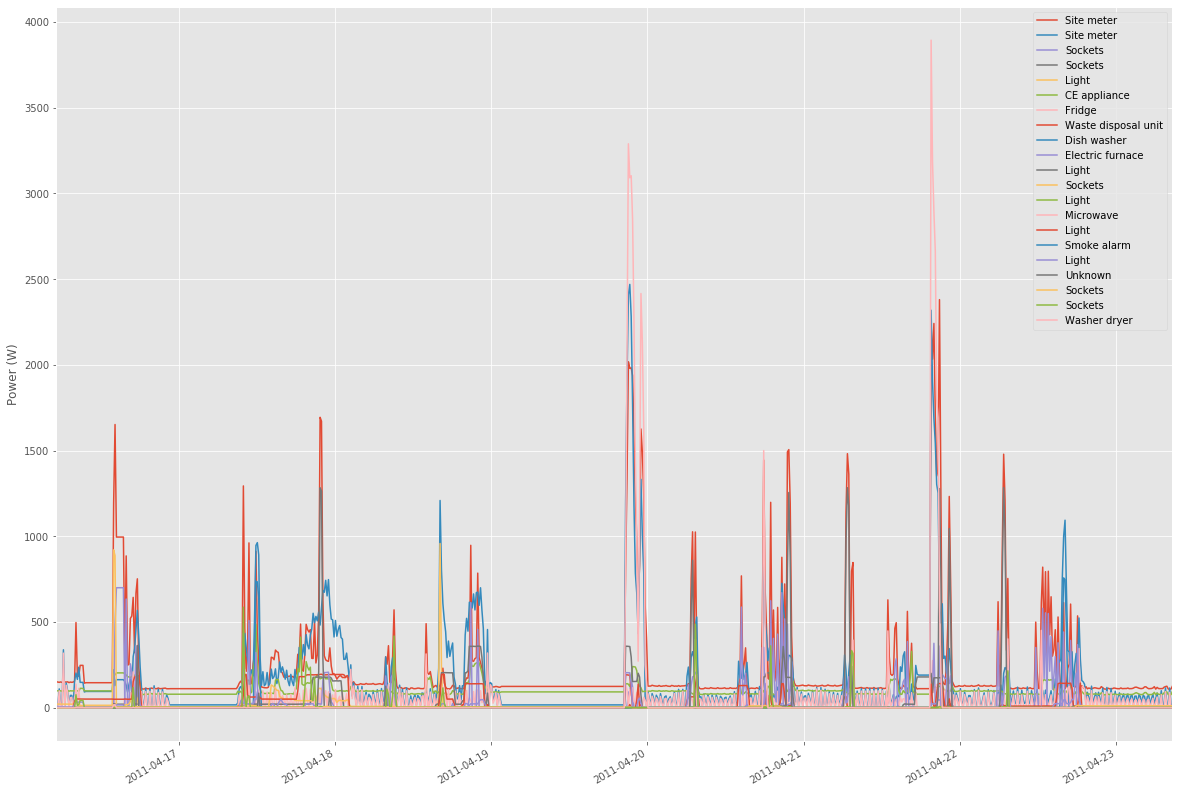

In [16]:
fig = plt.figure(figsize=(20, 15))
house_3.elec.plot();

Loading data for meter ElecMeterID(instance=13, building=3, dataset='REDD')      ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


<Figure size 1440x1080 with 0 Axes>

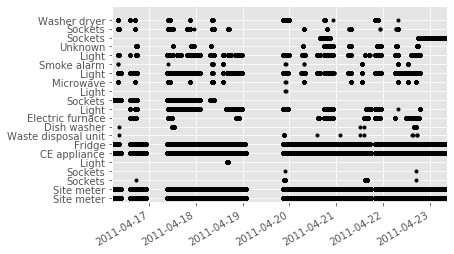

In [17]:
fig = plt.figure(figsize=(20, 15));
house_3.elec.plot_when_on();

In [18]:
top = house_3.elec.submeters().select_top_k(5, verbose=0)
print("\n")
print("Aparelhos com maiores consumo:")
print("------------------------------")
for e in top.meters:
    print( "#{} - {}".format( e.instance(), e.label() ))

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=13, building=3, dataset='REDD') ...    total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

Aparelhos com maiores consumo:
------------------------------
#6 - CE appliance
#(13, 14) - Washer dryer
#7 - Fridge
#10 - Electric furnace
#17 - Light


# Carregando dados e parâmetros
---

Janelas com submedições.

In [19]:
# Window size (5 minutes, after converted to seconds and divided by sample rate), 
# resulting in unit split of each chunk (window)

# window_length = int((1.5 * 60) / sample_rate)
window_length = int((60 * 60) / sample_rate) # (minutes * 60) / sample rate = 1 hora de amostras
window_length

1200

In [20]:
# Maximum size of series data (depending on window length)
series = house_3.elec.mains().power_series_all_data(sample_period=sample_rate)
series_limit = int(len(series.values)/window_length)*window_length
series_limit

Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')      ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


205200

In [21]:
start_timestamp = int(series.index[0].timestamp())
end_timestamp = int(series.index[series_limit].timestamp())

print("VALIDATED DATETIME INTERVAL:")
print()
print("- Initial datetime: {}".format( series.index[0].strftime(format="%d/%m/%Y %H:%M:%S") ) ) 
print("- Final datetime: {}".format( series.index[series_limit].strftime(format="%d/%m/%Y %H:%M:%S") )  )

VALIDATED DATETIME INTERVAL:

- Initial datetime: 16/04/2011 05:11:30
- Final datetime: 23/04/2011 08:11:30


In [22]:
# Carregando dados dos aparelhos
df_windows = pd.read_csv(os.path.join(windows_data_path, "df_windows.csv"))
df_rqa = pd.read_csv(os.path.join(windows_data_path, "df_rqa.csv"))

In [23]:
# Parâmetros RP
rp_params = {
    "dimension": 3,
    "time_delay": 8,
    "threshold": 0.1
}

# Exibir apenas aparelhos com maior consumo de energia na serie historica
top_appliances = [
    {"id": 6, "label": "CE appliance"},
    {"id": 13, "label": "Washer dryer"},
    {"id": 14, "label": "Washer dryer"},
    {"id": 7, "label": "Fridge"},
    {"id": 10, "label": "Electric furnace"},
    {"id": 17, "label": "Light"}
]

# EDA

## Funções Auxiliares

In [24]:
def scale(x, out_range=(-1, 1)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [25]:
def plot_serie(data, label):
    
    # Split series in windows
    #data = data.reshape(-1, window_length)
    fig, ax = plt.subplots(figsize=(20,5))
    
    # 
    if label != "Site meter":
        
        plt.plot(data, label=label)

        plt.title("Power Consumption - " + label);
        plt.ylabel("Power");
        plt.xlim(0, len(data)-1);

        plt.show();

## Informações Básicas

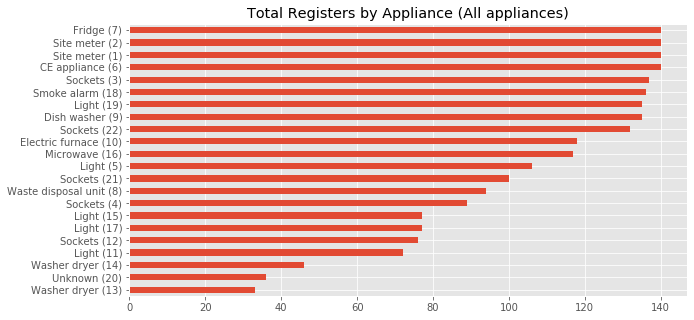

In [26]:
fig = plt.figure(figsize=(10,5))
df_windows["Appliance"].apply(lambda a: "{} ({})".format(a.split(" - ")[1], a.split(" - ")[0]) ).value_counts().sort_values(ascending=True).plot(kind="barh");
plt.title("Total Registers by Appliance (All appliances)");

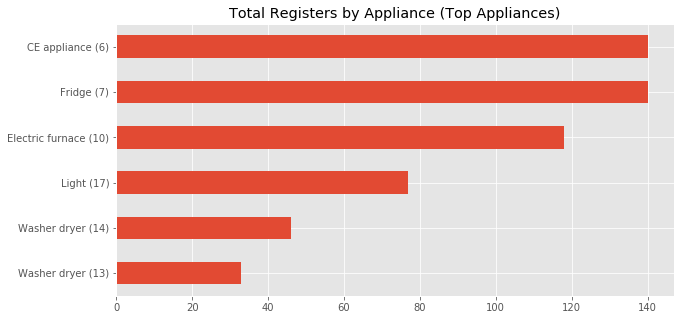

In [27]:
df_windows_top = df_windows[df_windows["Appliance"].isin(["{} - {}".format(a["id"], a["label"]) for a in top_appliances])]
df_windows_top.reset_index(inplace=True)
df_rqa_top = df_rqa[df_rqa["Appliance"].isin(["{} - {}".format(a["id"], a["label"]) for a in top_appliances])]
df_rqa_top.reset_index(inplace=True)

fig = plt.figure(figsize=(10,5))
df_windows_top["Appliance"].apply(lambda a: "{} ({})".format(a.split(" - ")[1], a.split(" - ")[0]) ).value_counts().sort_values(ascending=True).plot(kind="barh");
plt.title("Total Registers by Appliance (Top Appliances)");

# Comparação de Abordagens

## Machine Learning  + RQA - atributos selecionados a priori (Recorrência e Determinismo)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

kfolds = 10
score_function = 'accuracy'

"""
Pipeline 1: classificação se baseando na definição fixa de atributos de RQA para 
a classificação com modelo SVM. 

Atributos selectionados: Recorrencia e Determinismo.
"""
pipeline = Pipeline([
#     ('scaler', MinMaxScaler()),
    ('classification', SVC())
])

# Avaliando modelo...
scores = cross_val_score(
    pipeline,
    df_rqa_top[["Recurrence rate (RR)","Determinism (DET)"]].values, 
    df_rqa_top["Appliance"].values,
    cv = kfolds,
    scoring=score_function
)
print("Score médio do pipeline: {:.2f}%".format(scores.mean()*100))

Score médio do pipeline: 58.19%


## Machine Learning + RQA - Seleção automática de atributos

In [29]:
"""
Pipeline 2: classificação se baseando na seleção automática de atributos de RQA para 
a classificação com modelo SVM. 

Atributos selectionados: ...
"""
from collections import Counter
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


def pearson_corr_selection(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    y_ = pd.factorize(y)[0]
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i].values, y_)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

def ensemble_feature_selector(X, y, num_features = 5, k_features = 3):
    """
    Combinação de algoritmos para selecção de atributos.
    ---
    Argumentos:
        - X: subset do dataframe com os dados a serem avaliados;
        - y: Series com os registros do atributo alvo;
        - num_features: número de atributos a serem selecionados por cada algoritmo.    
        - k_features: k-top features + frequentes a partir dos algoritmos.
    """
    
    # Insumos para analise
    features_list = []
    features_by_selector = []
    
    # Tratando os dados para selecionadores que exigem normalizacao ou
    # output categorico (como chi2, por exemplo)
    X_norm = MinMaxScaler().fit_transform(X)
    y_factorized = pd.factorize(y)[0]

#     # MÉTODO 1: Pearson
#     support, features = pearson_corr_selection(X, y, num_features)
#     #features_by_selector.append(["PEARSON"] + cor_feature)
#     features_by_selector.append({"PEARSON": cor_feature})
#     features_list += features

    # MÉTODO 2: Chi-Squared (Filter-based)
    feature_selector = SelectKBest(chi2, k=num_features)
    feature_selector.fit(X_norm, y)
    support = feature_selector.get_support()
    features = X.loc[:,support].columns.tolist()
    #features_by_selector.append(["Chi-Squared"] + features)
    features_by_selector.append({"Chi-Squared": features})
    features_list += features
    
    # MÉTODO 3: Recursive Feature Elimination (Wrapped-based)
    feature_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_features, step=1, verbose=0)
    feature_selector.fit(X_norm, y)
    support = feature_selector.get_support()
    features = X.loc[:,support].columns.tolist()
    #features_by_selector.append(["RFE"] + rfe_feature)
    features_by_selector.append({"RFE": features})
    features_list += features
    
    # MÉTODO 4: Lasso (Embed-based)
    feature_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=num_features)
    feature_selector.fit(X_norm, y)
    support = feature_selector.get_support()
    features = X.loc[:,support].columns.tolist()
    #features_by_selector.append(["Lasso"] + features)
    features_by_selector.append({"LASSO": features})
    features_list += features
    
    # MÉTODO 5: Floresta aleatória (Embed-based)
    feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=num_features)
    feature_selector.fit(X, y)
    support = feature_selector.get_support()
    features = X.loc[:,support].columns.tolist()
    #eatures_selection.append(["Random-Forest"] + embeded_rf_feature)
    features_by_selector.append({"Random-Forest": features})
    features_list += features
    
    # Agrupando e contabilizando TOP-K features
    top_features = [key for key, count in Counter(features_list).most_common(k_features)]
    
    return top_features, features_by_selector, features_list

top_features, features_by_selector, features_list = ensemble_feature_selector(
    X = df_rqa_top[df_rqa_top.columns[3:-1].tolist()],
    y = df_rqa_top["Appliance"].values,
    num_features = 5,
    k_features=3
)

pipeline = Pipeline([
    ('classification', SVC())
])

# Avaliando modelo...
scores = cross_val_score(
    pipeline,
    df_rqa_top[top_features].values, 
    df_rqa_top["Appliance"].values,
    cv = kfolds,
    scoring=score_function
)
print("Score médio do pipeline: {:.2f}%".format(scores.mean()*100))

Score médio do pipeline: 66.45%


## Deep Learning + RP

In [30]:
"""
Pipeline 3: RP + CNN
"""
import random as rn
import skimage
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical, np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import *

# Configurações gerais dos algoritmos/ambientes de teste
SEED = 33
EPOCHS = 1000
BATCH_SIZE = 8
VERBOSE = 0

np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dcnn(input_shape_ = (128,128,3), output_dim=6, loss_function = 'binary_crossentropy', metrics=['accuracy', f1]):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss=[loss_function], metrics=metrics)
    
    return model

def vgg16(input_shape_ = (128,128,3), output_dim=6, loss_function = 'binary_crossentropy', metrics=['accuracy', f1]):
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = input_shape_
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(output_dim, activation='softmax')(x) #final layer with softmax activation
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
        loss=loss_function,
        metrics=metrics
    )
    
    return model

# def vgg16(input_shape_ = (128,128,3), output_dim=6, loss_function = 'binary_crossentropy', metrics=['accuracy', f1]):
#     base_model = VGG16(
#         weights='imagenet',
#         #weights = None,
#         include_top=False, #imports the mobilenet model and discards the last neuron layer.
#         input_shape = input_shape_
#     ) 
#     # mark loaded layers as not trainable
#     for layer in base_model.layers:
#         layer.trainable = False
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Flatten()(x)
#     x = Dense(128,activation='relu')(x) #dense layer 2
#     x = Dropout(0.5)(x)
#     x = Dense(64,activation='relu')(x) #dense layer 3
#     x = Dropout(0.5)(x)
    
#     output_layer = Dense(output_dim, activation='softmax')(x) #final layer with softmax activation
    
#     model = Model(
#         inputs  = base_model.input,
#         outputs = output_layer
#     )    
#     model.compile(
#         #optimizer=tf.keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
#         optimizer= tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95),
#         loss=loss_function,
#         metrics=metrics
#     )
    
#     return model

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [31]:
# Carregando dados RP
print("---> Loading RP images...")
X_rp = []
y_rp = []
plt.style.use('default')
plt.ioff()
for a in tqdm(top_appliances):
    rp_images_path = os.path.join(windows_data_path, "rp_analysis", "{}-{}".format(a["id"], a["label"].lower().replace(" ","_")) )
    for image_path in glob(rp_images_path+"/*-rp.png"):
        #img = skimage.io.imread(image_path).astype(int)
        img = np.array(Image.open(image_path).convert('RGB').resize((128,128)))
        X_rp.append(img)
        y_rp.append("{} - {}".format(a["id"], a["label"]))
X_rp = np.array(X_rp)
y_rp = to_categorical(LabelEncoder().fit(y_rp).transform(y_rp))
plt.ion()
plt.style.use('ggplot')
X_rp[X_rp > 0] = 1

---> Loading RP images...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


In [33]:
scores = []
print("---> Training CNN (VGG16) model...\n")

i = 1
for train_index, test_index in KFold(kfolds, random_state=SEED, shuffle=True).split(X_rp):
    
    # Spliting dataset
    print(" - Fold {}/{}...".format(i, kfolds))
    X_train, X_test = X_rp[train_index], X_rp[test_index]
    y_train, y_test = y_rp[train_index], y_rp[test_index]

    model = vgg16(
        input_shape_= X_rp[0,:,:].shape,
        output_dim = y_rp.shape[1],
        loss_function='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Calibrating model..
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = VERBOSE, #callbacks = callbacks_
    )
    
    score = model.evaluate(X_test, y_test)[1]
    scores.append(score)
    print("")
    print(" ----- Score parcial ({}/{}): {:.2f}%".format(i,kfolds,score*100))
    print("")
    
    i += 1
    
print("")
print("="*80)
print("Score médio do pipeline: {:.2f}%".format(np.array(scores).mean()*100))

---> Training CNN (VGG16) model...

 - Fold 1/10...
56/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

55/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Resultado Final

| Abordagem | Acurácia Média (10 CV-Folds) |
| --- | --- |
| SVM (RQA + Atributos `Recorrência` e `Determinismo`) | 58.19% |
| SVM (RQA + Ensemble Feature Selection) | 66.45% |
| Deep Learning VGG16 Model (RP Imaging Time-series) | 72.74% |

**CONCLUSÕES:**

Um dos grandes desafios na elaboração de um classificador baseado em IA é a adoção de uma ferramenta eficiente para a representação dos dados de entrada, de modo que esta lide bem com ruídos, outliers, além de codificar de modo consistente a natureza original do problema, mantendo a distribuição de classes a priori distintas.

No âmbito de classificação de séries temporais para a desagregação de energia (NILM) em baixa-frequência, estas ferramentas se tornam aindam mais importantes, uma vez que apenas a variação temporal e magnitude de consumo energético são as informações disponíveis.

Neste contexto surge o Gráfico de Recorrência (RP), o qual se baseia na transformação da série original em uma representação gráfica das recorrências do sistema dinâmico, permitindo realizar uma inspeção visual das medições. Ainda, a partir de estatístcas de tipologia e textura, é possível avaliar quantitativamente e qualitativamente os gráficos gerados, através dos indicadores de RQA.

Logo, introduzimos neste estudo uma avaliação completa a cerca da utilização dos RPs para os dados da base REDD, no qual foi possível avaliar que a adoção desta ferramenta permite extrairmos informações valiosas a cerca da distribuição do perfil de consumo de cada aparelho doméstico, principalmente dentre o grupo de aparelhos que mais consomem energia.

De modo geral, a ferramenta de RP demonstra grande poder de representação de series temporais, na qual os gráficos resultantes conseguem gerar estatísticas suficientemente discrimativas, comportamento este desejável para aplicações no contexto de aprendizado de máquina.


Portanto, o estudo apresentado compara 3 abordagens distintas para resolução da classificação de cargas, sendo 2 utilizando um classificador SVM a partir das estatísticas de RQA (o **método #1** selecionando `Recorrência` e `Determinismo`, e o **método #2** implementando um método Ensemble de Seleção de atributos de RQA) e 1 implementando uma **Rede Neural Convolucional** (arquitetura VGG16, com transfer learning aplicado a camada de saída com pesos do dataset ImageNET) diretamente nos RPs, no qual esta última alternativa demonstrou a maior eficiência no problema em questão, corroborando a hipótese deste projeto de pesquisa.